In [1]:
using Pkg
Pkg.activate("..")

using Distributions, LinearAlgebra, MiCRM, EasyFit, Distances, StatsBase, Clustering
using OrdinaryDiffEq, DiffEqCallbacks
using CairoMakie, Colors, ColorSchemes
using JLD2
using Optim, ForwardDiff

  Activating project at `~/Projects/Working/ErCite/chemicalstressors`


In [2]:
Pkg.status()

Status `~/Projects/Working/ErCite/chemicalstressors/Project.toml`
⌃ [13f3f980] CairoMakie v0.10.0
  [aaaa29a8] Clustering v0.14.3
  [35d6a980] ColorSchemes v3.20.0
⌃ [5ae59095] Colors v0.12.8
  [459566f4] DiffEqCallbacks v2.24.3
  [b4f34e82] Distances v0.10.7
  [31c24e10] Distributions v0.25.79
  [fde71243] EasyFit v0.5.7
⌃ [f6369f11] ForwardDiff v0.10.32
  [033835bb] JLD2 v0.4.29
⌅ [20f20a25] MakieCore v0.6.0
  [a39c0ef7] MiCRM v0.0.2 `https://github.com/CleggTom/MiCRM.jl.git#main`
  [429524aa] Optim v1.7.4
⌃ [1dea7af3] OrdinaryDiffEq v6.35.1
  [2913bbd2] StatsBase v0.33.21
⌃ [0c5d862f] Symbolics v4.13.0
Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ cannot be upgraded. To see why use `status --outdated`


# Introduction

In this notebook I do some exploratory analysis of a model in which stressors are linked to consumer dynamics by uptake. This uptake has negative consequences for consumers and removes the resources from the environment. 

The basic model is as follows:
\begin{align}
    \frac{dC}{dt} &= C_i \left(\sum_{\alpha} R_{\alpha} u_{i \alpha} \gamma_{\alpha}(1 - \lambda) - m_i\right)\\
    \frac{dR}{dt} &= \rho_\alpha - R_{\alpha} \omega_\alpha - \sum_{i} C_i  R_{\alpha} u_{i \alpha} + \sum_{\beta} R_{\beta} \sum_{i} C_i u_{i \beta} l_{\beta \alpha}
\end{align}

Or in a diagram:

<center>
<img src="figs/StressorDiagram.png" width="400">
</center>

Consumers uptake and leak resources as normal. The stressor acts as a resource but has a negative effect on growth of consumer populations. 

## Code

In [3]:
#solve system with stressor
#derivatives
function growth_MiCRM_detox!(dx,x,p,t,i)
    #mortality
    dx[i] += -p.m[i] * x[i]
    #resource uptake
    for α = 1:p.M
        tmp = 0.0
        for β = 1:p.M
            tmp += p.l[α,β]
        end
        dx[i] += x[α + p.N] * x[i] * p.u[i,α] * (1 - tmp) * p.kw.γ[i,α]
    end
end

#derivative function
dx!(dx,x,p,t) = MiCRM.Simulations.dx!(dx,x,p,t; growth! = growth_MiCRM_detox!)


#params
function fu(N,M,kw)
    u = zeros(N,M)
    u[:, 1 : (M-1)] .= MiCRM.Parameters.modular_uptake(N,M - 1, N_modules = 5, s_ratio = kw[:u_ratio]) * kw[:u_tot]
    u[:, end] .= ones(N)
    return(u)
end

function fl(N,M,kw)
    l = MiCRM.Parameters.modular_leakage(M; N_modules = 5, s_ratio = kw[:l_ratio], λ = kw[:λ])
    #dont leak to or from stressor
    l[:,end] .= 0.0
    l[end,:] .= 0.0
    [l[i,:] .=  kw[:λ] * l[i,:] ./ sum(l[i,:]) for i = 1:(M-1)]
    return(l)
end

#Dirchlet U matricies
function dirchlet_uptake(N,M,kw)
    u = zeros(N,M)
    u[:,1 : end-1] .= Array(rand(Dirichlet(M-1, kw[:au]), N)')
    u[:,end] .= rand(Dirichlet(N, 1.0), 1)
    return(u)
end

#Dirchlet L matricies
function dirchlet_leakage(N,M,kw)
    l = zeros(M,M)
    for α = 1:M-2
        l[α, α+1 : end-1] .= rand(Dirichlet(M - 1 - α, kw[:al]), 1)
    end
    # l[1 : end-1, 1 : end-1] .= Array(rand(Dirichlet(M-1, kw[:al]), M-1)')
    return(l * kw[:λ])
end

function fρ(N,M,kw)
    ρ = zeros(M) 
    ρ[1] = M * M
    ρ[end] = 0.0
    return(ρ)
end

f_ω(N,M,kw) = fill(1.0, M)

f_ω (generic function with 1 method)

In [355]:
N,M = 1,25

#gamma
γ = ones(N,M)
γ[:,end] .= -1.0

#generate test parameters
p = MiCRM.Parameters.generate_params(N, M, f_u = dirchlet_uptake, f_l = dirchlet_leakage, f_ρ = fρ, λ = 0.7, γ = γ, au = 0.2, al = 1.0)

#simualtion params
x0 = ones(N+M)
x0[end] = 0.0
t = (0.0,1e5)

prob = ODEProblem(dx!, x0, t, p)

@time sol1 = solve(prob, AutoTsit5(Rosenbrock23()));
@time sol2 = solve(prob, AutoTsit5(Rosenbrock23()), callback = TerminateSteadyState(1e-8,1e-6));

  0.002048 seconds (510 allocations: 134.141 KiB)
  0.001390 seconds (477 allocations: 121.734 KiB)


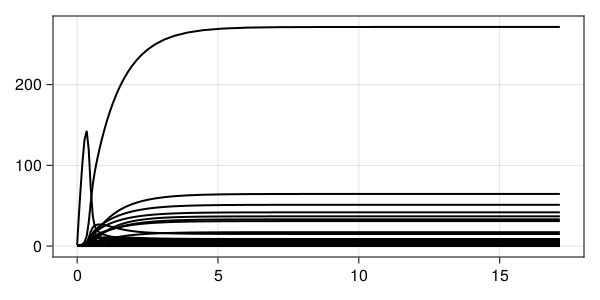

In [356]:
plot_sol(sol,ax) = Makie.series!(ax, sol.t, sol[:,:], solid_color = "black")

f = Figure(resolution = (600,300))
ax = Axis(f[1,1])
plot_sol(sol2,ax)
f

# Simulation details

## Measuring responses

we consider three aspects of the stress response over different timescales. 

1. Degree of amplification of a pulse of chemical stressor
2. The rate of return after a pulse of chemical stressor
3. The change in equilbirium state following chronic exposure to the stressor. 

<img src="figs/pulse.png" width="400">


## Interactions

We consider how these responses are modified by the community context and how interactions between consumer populations affect the response. 

* cooperation increases robustness? (Oña 2022)

* competition increases sensitvtiy (Violle et al. 2010)


### partitioning leakage and competition

To partition the contributions of leakage and competition for resources we first consider the dyanmic equations, extracting the total effects of uptake and leakage on the $\alpha^{\text{th}}$ resource:

\begin{align}
    L_{\alpha} &= \sum_{i \beta} C_i R_{\beta} u_{i \beta} l_{\beta \alpha}, \\
    U_{\alpha} &= \sum_{i} C_i R_{\alpha} u_{i \alpha}.
\end{align}

We then consdier how these fluxes are affected by consumer species with the quantites:

\begin{align}
    \frac{d L_{\alpha}}{d C_i} &= \sum_{\beta} R_{\beta} u_{i \beta} l_{\beta \alpha}, \\
    \frac{d U_{\alpha}}{d C_i} &= R_{\alpha} u_{i \alpha},
\end{align}

and weight their effects on consumers by considering the effect of resources from consumer growth

\begin{align}
    \frac{d g_i}{d R_{\alpha}} = u_{i \alpha} \gamma_{i \alpha} (1 - \lambda)
\end{align}

thus the effect of consumer $j$ on $i$ due to leakage and uptake respectively are:
\begin{align}
    a^{L}_{i j} &= \sum_{\alpha} \frac{d g_i}{d R_{\alpha}} \frac{d L_{\alpha}}{d C_j} = \sum_{\alpha} \big[u_{i \alpha} \gamma_{i \alpha} (1 - \lambda) \big] \big[\sum_{\beta} R_{\beta} u_{j \beta} l_{\beta \alpha} \big] \\
    a^{U}_{i j} &= \sum_{\alpha} \frac{d g_i}{d R_{\alpha}} \frac{d U_{\alpha}}{d C_j} = \sum_{\alpha} \big[u_{i \alpha} \gamma_{i \alpha} (1 - \lambda) \big] \big[R_{\alpha} u_{j \alpha} \big]
\end{align}

In [357]:
dgdR(p, R, i, a) = p.u[i,a] * p.kw.γ[i,a] * (1 - p.kw.λ)

function dLdC(p, R, j, a)
    v = 0.0
    for b = 1:p.M
        v += p.l[b,a] * R[b] * p.u[j,b]
    end
    return v
end

dUdC(p, R, j, a) = R[a] * p.u[j,a]

function a_L(p,R,i,j)
    v = 0.0
    for a = 1:p.M
        v += dgdR(p,R,i,a) * dLdC(p,R,j,a)
    end
    return(v)
end

function a_U(p,R,i,j)
    v = 0.0
    for a = 1:p.M
        v += dgdR(p,R,i,a) * dUdC(p,R,j,a)
    end
    return(v)
end

get_U_mat(p,R) = [a_U(p,R,i,j) for i = 1:p.N , j = 1:p.N]
get_L_mat(p,R) = [a_L(p,R,i,j) for i = 1:p.N , j = 1:p.N]

get_L_mat (generic function with 1 method)

In [7]:
# get_U_mat(p,R)
# get_L_mat(p,R)

# @time a_U_mat = get_U_mat(p,R)
# @time a_L_mat = get_L_mat(p,R);

In [8]:
function treepositions(hc::Hclust; useheight = true, orientation = :vertical)
    order = StatsBase.indexmap(hc.order)
    nodepos = Dict(-i => (float(order[i]), 0.0) for i in hc.order)
    xs = []
    ys = []
    for i in 1:size(hc.merges, 1)
        x1, y1 = nodepos[hc.merges[i, 1]]
        x2, y2 = nodepos[hc.merges[i, 2]]
        xpos = (x1 + x2) / 2
        ypos = useheight ?  hc.heights[i] : (max(y1, y2) + 1)
        nodepos[i] = (xpos, ypos)
        push!(xs, [x1, x1, x2, x2])
        push!(ys, [y1, ypos, ypos, y2])
    end
    if orientation == :horizontal
        return ys, xs
    else
        return xs, ys
    end
end
function dendrogram(h; color = :blue, kwargs...)
    CairoMakie.Axis(Figure()[1, 1])
    for (x, y) in zip(treepositions(h; kwargs...)...)
        lines!(x, y; color)
    end
    current_figure()
end

dendrogram (generic function with 1 method)

  0.000043 seconds (1 allocation: 5.062 KiB)
  0.000324 seconds (1 allocation: 5.062 KiB)


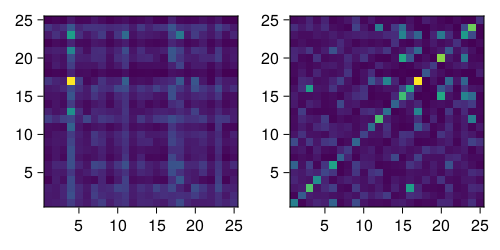

In [9]:
R = sol1[end][p.N+1 : end]

get_U_mat(p,R)
get_L_mat(p,R)

@time a_U_mat = get_U_mat(p,R)
@time a_L_mat = get_L_mat(p,R)

c = Clustering.hclust(Symmetric(a_U_mat))

f = Figure(resolution = (500,250))

ax1 = Axis(f[1,1])
ax2 = Axis(f[1,2])

heatmap!(ax1, a_L_mat[c.order,c.order])
heatmap!(ax2, a_U_mat[c.order,c.order])

f

## Resource Specialisation $s$
the degree to which consumers tend to specialise on their own resources

<center>
<img src="figs/Uptake_spec.png" width="400">
</center>

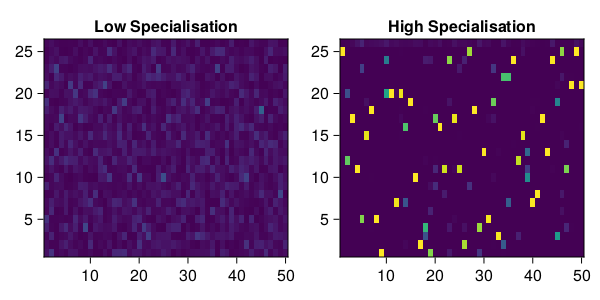

In [10]:
f = Figure(resolution = (600,300))

ax1 = Axis(f[1,1],title = "Low Specialisation")
ax2 = Axis(f[1,2],title = "High Specialisation")

heatmap!(ax1, dirchlet_uptake(50,26,Dict(:au => 1.0)), colorrange = (0.0,1.0))
heatmap!(ax2, dirchlet_uptake(50,26,Dict(:au => 0.01)), colorrange = (0.0,1.0))

f

## Leakage $\lambda$
The amount of resources leaked as metabolic by-products

<center>
<img src="figs/Leakage.png" width="400">
</center>

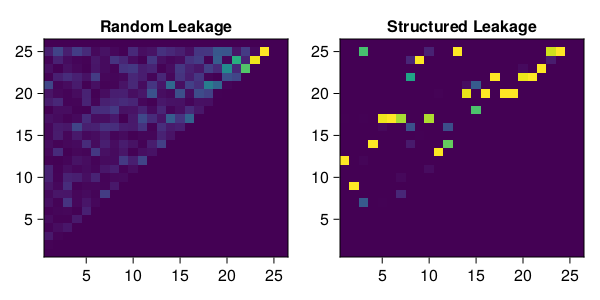

In [11]:
f = Figure(resolution = (600,300))

ax1 = Axis(f[1,1],title = "Random Leakage")
ax2 = Axis(f[1,2],title = "Structured Leakage")

heatmap!(ax1, dirchlet_leakage(50,26,Dict(:al => 1.0, :λ => 1.0)), colorrange = (0.0,1.0))
heatmap!(ax2, dirchlet_leakage(50,26,Dict(:al => 0.01, :λ => 1.0)), colorrange = (0.0,1.0))

f

In [358]:
r = JLD2.load("../data/detox_simulations.jld2")
# analysis = JLD2.load("../data/analysis.jld2")

N_r,N_u,N_λ,N_ρ = size(r["J"])

u_vec = -range(-2, 0, length = N_u)
ρ_vec = [0.0, 0.1, 1.0, 25, 150]
λ_vec = [0.1, 0.3, 0.7]

mean_no_diag(A) = (sum(A) - sum(A[diagind(A)])) / (prod(size(A) .- [0, 1]))

mean_no_diag (generic function with 1 method)

In [359]:
#get summaries
get_C(x) = sum(x[1:25])
get_R(x) = sum(x[26:end-1])
get_N(x) = sum(x[1:25] .> eps())

#functional measures
function uptake_flux(x,p)
    up = 0.0
    
    for i = 1:p.N
        #resource uptake
        for α = 1:p.M - 1 
            up += x[α + p.N] * x[i] * p.u[i,α]
        end
    end
    return(up)
end

function leakage_flux(x,p)
    x[end]
end
    

leakage_flux (generic function with 1 method)

In [401]:
C_mass = get_C.(r["mass"])
R_mass = get_R.(r["mass"]);
N_comm = get_N.(r["mass"])
up_flux = uptake_flux.(r["mass"],r["p"])
le_flux = leakage_flux.(r["mass"],r["p"])



# #relative mass
ΔC = similar(C_mass)
ΔR = similar(C_mass)
ΔN = similar(C_mass)
ΔU = similar(C_mass)
ΔL = similar(C_mass)


for rep = 1:size(C_mass)[1]
    ΔC[rep,:,:,:] = (C_mass[rep,:,:,:] .- C_mass[rep,:,:,1]) 
    ΔR[rep,:,:,:] = (R_mass[rep,:,:,:] .- R_mass[rep,:,:,1]) 
    ΔN[rep,:,:,:] = (N_comm[rep,:,:,:] .- N_comm[rep,:,:,1])
    ΔU[rep,:,:,:] = (up_flux[rep,:,:,:] .- up_flux[rep,:,:,1]) 
    ΔL[rep,:,:,:] = (le_flux[rep,:,:,:])
end


ΔC[isnan.(ΔC)] .= 0.0
ΔR[isnan.(ΔR)] .= 0.0
ΔN[isnan.(ΔN)] .= 0.0
ΔU[isnan.(ΔU)] .= 0.0
ΔL[isnan.(ΔL)] .= 0.0

3-element view(::Vector{Float64}, [28154, 28279, 28592]) with eltype Float64:
 0.0
 0.0
 0.0

# Results

### Change in Biomass

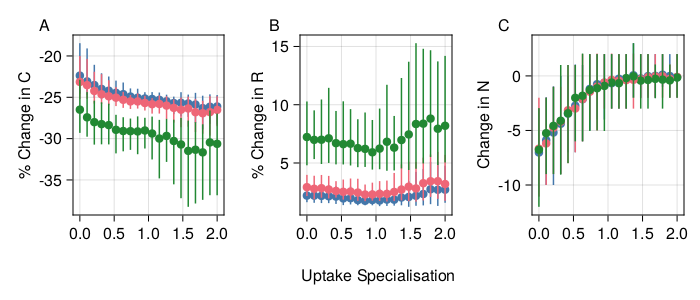

In [402]:
f = Figure(resolution = (700,300))

ax_C = Axis(f[1,1], ylabel = "% Change in C")
ax_R = Axis(f[1,2], ylabel = "% Change in R")
ax_N = Axis(f[1,3], ylabel = "Change in N")


Label(f[2,1:3], "Uptake Specialisation")

Label(f[1,1,TopLeft()],["A"])
Label(f[1,2,TopLeft()],["B"])
Label(f[1,3,TopLeft()],["C"])


label = string.(λ_vec)
c = ColorSchemes.tol_bright[1:3]

function bounds(x)
    #error
    lb = (mean(x) - quantile(x,0.05))
    ub = (quantile(x,0.95) - mean(x))

    return(lb,ub)
end

ρ = 4

for u = 1:N_u
    for l = 1:N_λ
        ΔC_plt = ΔC[:,u,l,ρ] 
        ΔR_plt = ΔR[:,u,l,ρ] 
        ΔN_plt = ΔN[:,u,l,ρ] 
        
        #mean
        scatter!(ax_C, u_vec[u], mean(ΔC_plt), color = c[l], label = label[l])
        scatter!(ax_R, u_vec[u], mean(ΔR_plt), color = c[l], label = label[l])
        scatter!(ax_N, u_vec[u], mean(ΔN_plt), color = c[l], label = label[l])


        lb,ub = bounds(ΔC_plt)
        errorbars!(ax_C, u_vec[u], mean(ΔC_plt),[lb],[ub],color = c[l])
        
        lb,ub = bounds(ΔR_plt)
        errorbars!(ax_R, u_vec[u], mean(ΔR_plt),[lb],[ub],color = c[l]) 
        
        lb,ub = bounds(ΔN_plt)
        errorbars!(ax_N, u_vec[u], mean(ΔN_plt),[lb],[ub],color = c[l]) 
    end
end

# axislegend(ax_C, ax_C, "λ", unique = true, position = :lb)

# save("../figures/consumer_resource.pdf",f)

f

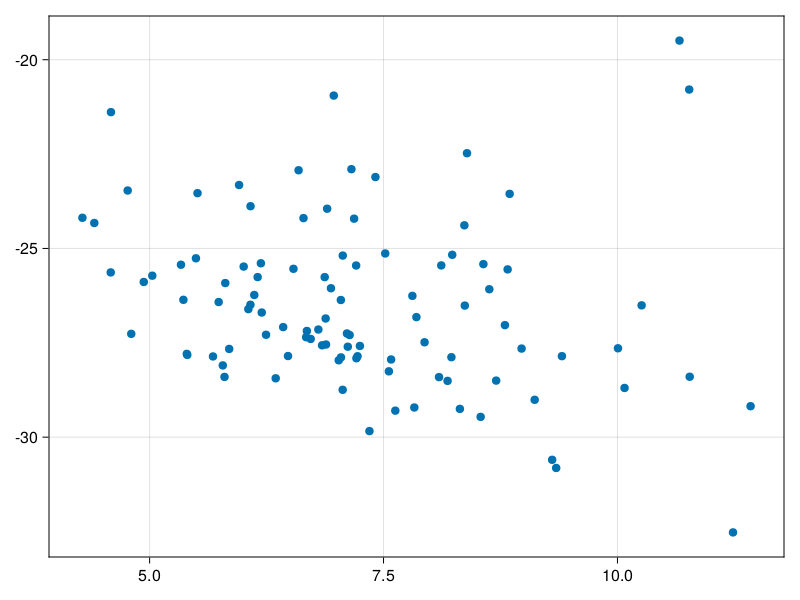

In [326]:
scatter(ΔR[:,end,3,4][:], ΔC[:,end,3,4][:])

In [354]:
R = diagm(sol2[end][26 : end])
C = sol2[end][1:25]

p.ρ - (R * p.ω) - (I - p.l') * R * (p.u' * C)

25-element Vector{Float64}:
 -1.895500645332504e-9
 -3.3937956889218412e-9
 -3.584235686027171e-11
 -8.482974322987502e-10
  1.2818051065011105e-9
  3.971332596108823e-9
 -5.678846282108907e-11
  5.5788706987414116e-11
 -6.101291694093902e-11
 -6.969411159296612e-11
  1.0538064643128564e-8
 -9.504064202303653e-10
  2.7369884136874134e-10
 -2.1687707185691352e-10
 -2.508679486368237e-9
  2.3759443301685224e-9
  8.627445424735924e-10
  7.237632715373365e-10
  1.8105683619040747e-10
 -1.523681625315021e-9
 -6.265947760653034e-10
 -2.3306956364876896e-10
  5.0898103509666726e-9
 -1.426501139434322e-10
  0.0

In [352]:
-p.l'

25×25 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.0         -0.0         -0.0          …  -0.0       -0.0  -0.0  -0.0
 -0.00704929  -0.0         -0.0             -0.0       -0.0  -0.0  -0.0
 -0.0166098   -0.00228438  -0.0             -0.0       -0.0  -0.0  -0.0
 -0.0359188   -0.00774571  -0.0477224       -0.0       -0.0  -0.0  -0.0
 -0.0373261   -0.0251169   -0.0631253       -0.0       -0.0  -0.0  -0.0
 -0.0503731   -0.00242332  -0.0273632    …  -0.0       -0.0  -0.0  -0.0
 -0.00135153  -0.0103846   -0.000720062     -0.0       -0.0  -0.0  -0.0
 -0.00471435  -0.0300635   -0.00939179      -0.0       -0.0  -0.0  -0.0
 -0.00663486  -0.0910321   -0.102477        -0.0       -0.0  -0.0  -0.0
 -0.00253556  -0.0162937   -0.0167369       -0.0       -0.0  -0.0  -0.0
 -0.0697417   -0.0413496   -0.0417027    …  -0.0       -0.0  -0.0  -0.0
 -0.039685    -0.0619929   -0.0908286       -0.0       -0.0  -0.0  -0.0
 -0.00953357  -0.0562912   -0.0367151       -0.0       -0.0  -0.0  -0.0
 -0.009791

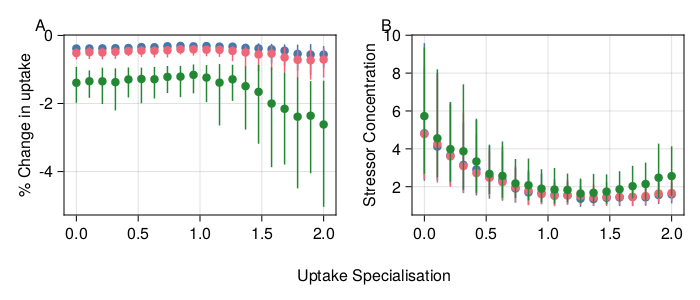

In [263]:
f = Figure(resolution = (700,300))

ax_U = Axis(f[1,1], ylabel = "% Change in uptake")
ax_L = Axis(f[1,2], ylabel = "Stressor Concentration")

Label(f[2,1:2], "Uptake Specialisation")

Label(f[1,1,TopLeft()],["A"])
Label(f[1,2,TopLeft()],["B"])

label = string.(λ_vec)
c = ColorSchemes.tol_bright[1:3]

ρ = 4

for u = 1:N_u
    for l = 1:N_λ
        ΔU_plt = ΔU[:,u,l,ρ]
        ΔL_plt = ΔL[:,u,l,ρ]
        
        #mean
        scatter!(ax_U, u_vec[u], mean(ΔU_plt), color = c[l], label = label[l])
        scatter!(ax_L, u_vec[u], mean(ΔL_plt), color = c[l], label = label[l])

        lb,ub = bounds(ΔU_plt)
        errorbars!(ax_U, u_vec[u], mean(ΔU_plt),[lb],[ub],color = c[l])
        
        lb,ub = bounds(ΔL_plt)
        errorbars!(ax_L, u_vec[u], mean(ΔL_plt),[lb],[ub],color = c[l])        
    end
end

# CairoMakie.current_axis!(ax_U)
# axislegend(ax_U, ax_U, "λ", unique = true, position = :lb)

save("../figures/Functioning.pdf",f)

f

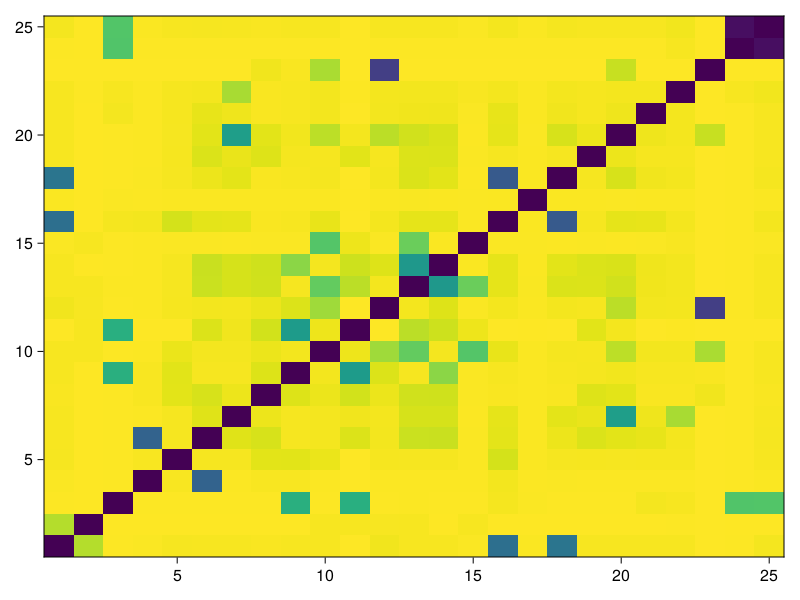

In [303]:
using Distances

u = dirchlet_uptake(10,100, Dict(:au => 1.0))

dist_mat = pairwise(jaccard, eachcol( r["p"][1,2,1,1].u' ))

heatmap(dist_mat, colorrange = (0,1))

In [304]:
mean_no_diag(dist_mat)

0.9576088348955737

# Mechanisms
So what could be driving the increased sensitvity in specialised communties?

In [ ]:
# Differences in effects of stressors?

In [193]:
## Mechanisms

#Which species?

dx = similar(r["mass"])
indx = similar(dx)

for rep = 1:N_r, i = 1:N_u, j = 1:N_λ, ρ = 1:N_ρ
    indx[rep,i,j,ρ] = findall(r["mass"][rep,i,j,ρ][1:25] .> eps())
    dx[rep,i,j,ρ] = r["mass"][rep,i,j,ρ][indx[rep,i,j,ρ]] .- r["mass"][rep,i,j,1][indx[rep,i,j,ρ]]   
    
end

cormat = similar(dx, Float64)

for rep = 1:N_r, i = 1:N_u, j = 1:N_λ, ρ = 4
    cormat[rep,i,j,ρ] = cov(dx[rep,i,j,ρ], r["p"][rep,i,j,ρ].u[indx[rep,i,j,ρ],end])
end

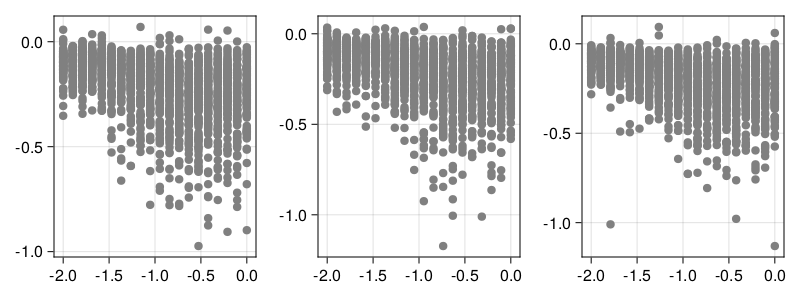

In [194]:
f = Figure(resolution = (800,300))
ax = [Axis(f[1,i]) for i = 1:3]

for u = 1:N_u
    [scatter!(ax[i], fill(u_vec[u],N_r), cormat[:,u,i,4], color = "grey") for i = 1:3]
end

f


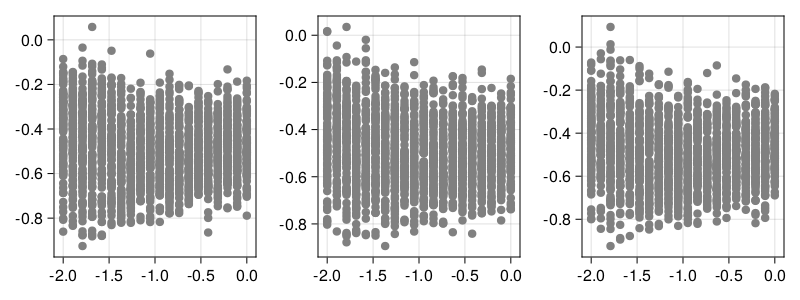

## redundancy

Are the specialised communtiies more sensitive because they have less redundancy?

stressors affect consumers, can the others take up their resources?

Are unexploited resources the cause for the de

In [22]:
function cor_redundancy(i,j,k,l)

    x1 = r["mass"][i,j,k,1][1:25]
    x2 = r["mass"][i,j,k,l][1:25]

    #change in biomass
    dC = x1 .- x2

    x1 = r["mass"][i,j,k,1][26:49]
    x2 = r["mass"][i,j,k,l][26:49]
    dR = x1 .- x2

    u = r["p"][i,j,k,1].u[:, 1:24]

    dR_ = u' * dC
    
    indx = x1 .> eps()
    
    return cor(dR[indx],dR_[indx])
end

cor_mat = zeros(N_r, N_u, N_λ)

for i = 1:N_r
    for j = 1:N_u
        for k = 1:N_λ
            cor_mat[i,j,k] = cor_redundancy(i,j,k,4)
        end
    end
end

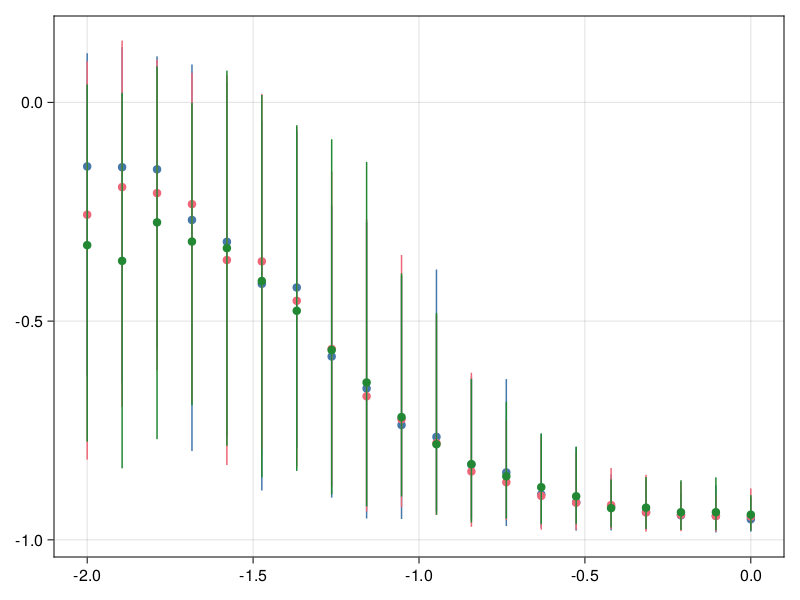

In [23]:
f = Figure()
ax = Axis(f[1,1])

for u = 1:N_u
    for l = 1:N_λ
        #mean
        scatter!(ax, u_vec[u], mean(cor_mat[:,u,l]), color = c[l], label = label[l])

        lb,ub = bounds(cor_mat[:,u,l])
        errorbars!(ax, u_vec[u], mean(cor_mat[:,u,l]),[lb],[ub],color = c[l])

    end
end

f

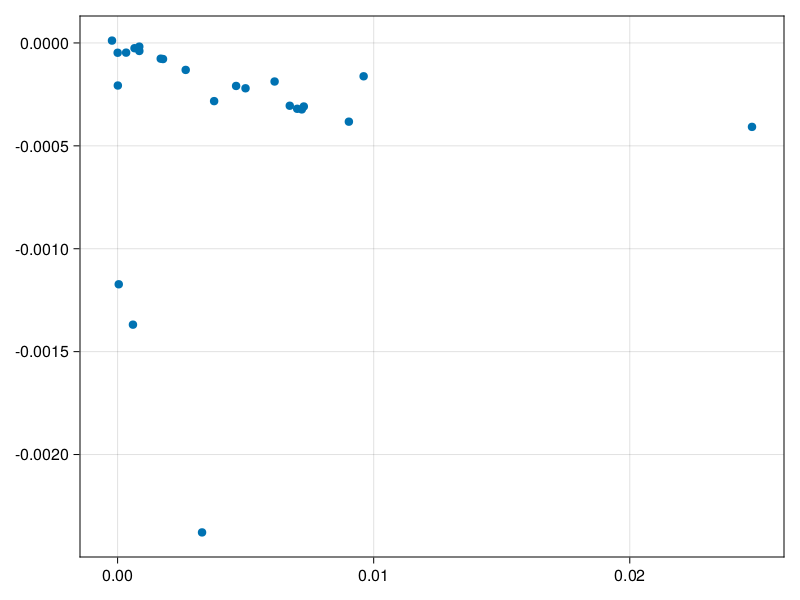

In [373]:
i,j,k = i,1,1

x1 = r["mass"][i,j,k,1][1:25]
x2 = r["mass"][i,j,k,l][1:25]

#change in biomass
dC = x1 .- x2

x1 = r["mass"][i,j,k,1][26:49]
x2 = r["mass"][i,j,k,l][26:49]

#change in resources
dR = x1 .- x2

u = r["p"][i,j,k,1].u[:, 1:24]

dR_ = u' * dC

scatter(dR_, dR)

In [109]:
leakage_flux(r["mass"][1,1,1,1],r["p"][1,1,1,1]) / leakage_flux(r["mass"][1,1,1,5],r["p"][1,1,1,5])

1.0376199603029352

In [15]:
r = JLD2.load("../data/detox_simulations_rand.jld2")

cor_mat = map(x -> cor(x.kw.au, x.u[:,end]), r["p"])

C_mass = get_C.(r["mass"])
R_mass = get_R.(r["mass"]);
up_flux = get_uptake_flux.(r["mass"],r["p"])

#unstable solutions


# #relative mass
ΔC = similar(C_mass)
ΔR = similar(C_mass)
ΔU = similar(C_mass)


for rep = 1:size(C_mass)[1]
    ΔC[rep,:,:,:] = 100((C_mass[rep,:,:] .- C_mass[rep,:,1]) ./ C_mass[rep,:,1])
    ΔR[rep,:,:,:] = 100((R_mass[rep,:,:] .- R_mass[rep,:,1]) ./ R_mass[rep,:,1])
    ΔU[rep,:,:,:] = 100((up_flux[rep,:,:] .- up_flux[rep,:,1]) ./ up_flux[rep,:,1])
    
    # ΔC[rep,:,:,:] = (C_mass[rep,:,:,:] .- C_mass[rep,:,:,1])
    # ΔR[rep,:,:,:] = (R_mass[rep,:,:,:] .- R_mass[rep,:,:,1])
    # ΔU[rep,:,:,:] = (up_flux[rep,:,:,:] .- up_flux[rep,:,:,1])
end


LoadError: UndefVarError: get_C not defined

In [18]:
cor_mat = similar(r["mass"], Float64)

for i = eachindex(r["p"])
    extant_ind = findall(r["mass"][i][1:25] .> eps())
    if !isempty(extant_ind)
        cor_mat[i] = cor(r["p"][i].kw.au[extant_ind], r["p"][i].u[extant_ind,end])
    else
        cor_mat[i] = NaN
    end
end

In [16]:
cor(cor_mat[:,1,8], ΔC[:,1,8])

NaN

In [32]:
cor(cor_mat[:,2,8][.!isnan.(cor_mat[:,2,8])], ΔC[:,2,8][.!isnan.(cor_mat[:,2,8])])

0.27035753226686104

### Interpretation

Overall the system response to stressors seems stronger in specialised communites. There is no differnce in the intrinsic susceptability 

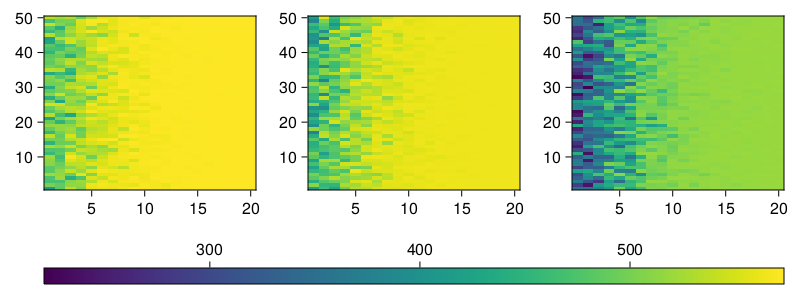

In [202]:
f = Figure(resolution = (800,300))

ax = [Axis(f[1,i]) for i = 1:3]
[heatmap!(ax[i], C_mass[:,:,i,1]', colorrange = extrema(C_mass[:,:,:,1])) for i = eachindex(ax)] 
Colorbar(f[2,1:3],colorrange = extrema(C_mass[:,:,:,1]), vertical = false)

f

In [168]:
heatmap

LoadError: ArgumentError: start and stop must be finite, got NaN and NaN

# approximations

\begin{align}
        R_{tot}^* &\approx \frac{\bar{m} +u_s R_s^*}{\bar{u} (1 - \lambda)} \\
        C_{tot}^* &\approx \frac{\rho_{tot} - \omega_{tot}}{(1 - \lambda) \bar{u} R_{tot}^*} = \frac{\rho_{tot} - \omega_{tot}}{\bar{m} +u_s R_s^*}
\end{align}

Adding stressor will increase resource abundance but reduce consumer biomass

\begin{align}
    u_{tot} = (1-\lambda) \sum_{i,\alpha} u_{i \alpha} C_i R_i \approx \bar{u} R_{tot} C_{tot} = \frac{\rho_{tot} - \omega_{tot}}{(1 - \lambda)}
\end{align}

In [381]:
#testing quantities
f_Rtot(p,Rs) = mean(p.m + p.u[:,end] * Rs) / (mean(p.u[:,1:24]) * (1 - p.kw.λ))
f_Ctot(p,Rs) = (sum(p.ρ) - f_Rtot(p, Rs))/((1 - p.kw.λ)*mean(p.u[:,1:24]) * f_Rtot(p,Rs))
f_Rs(p,Ctot) = p.ρ[end] / (p.ω[end] + Ctot) 
f_U(p, Rs) = (sum(p.ρ) - f_Rtot(p, Rs)) / (1 - p.kw.λ)

f_U (generic function with 1 method)

In [398]:
p_ = r["p"][1,end,1,4]
m_ = r["mass"][1,end,1,4];

In [400]:
println("resources: ", sum(m_[26:end-1]),"  ",f_Rtot(p_,m_[end]))
println("Consumers: ", sum(m_[1:25]),"  ",f_Ctot(p_,m_[end]))
println("Stressor: ",  m_[end],"  ",f_Rs(p_,f_Ctot(p_,m_[end])))

println("Uptake: ", m_[26:end-1]' * p_.u[:, 1:24]' * m_[1:25],"  ", f_U(p_, m_[end]))

resources: 28.811884314434028  30.770322192095534
Consumers: 550.0352927406554  514.9807870914905
Stressor: 3.8471770550895634  0.048451416458588324
Uptake: 634.6534618744646  660.2551975643382
